Betweenness
high nodes [222 246  14 234  42  31 131 174 242  53 197 188 107 217  35  92 235   2
 245  63  28 204 240 100 192 114 196 106  88 210 173  23  70  98  97 172
 199  85  41 158 138  45 105  54  43 128 139 189 162 110]
Разница между mod и orig: 32.23053030006706 %
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 1

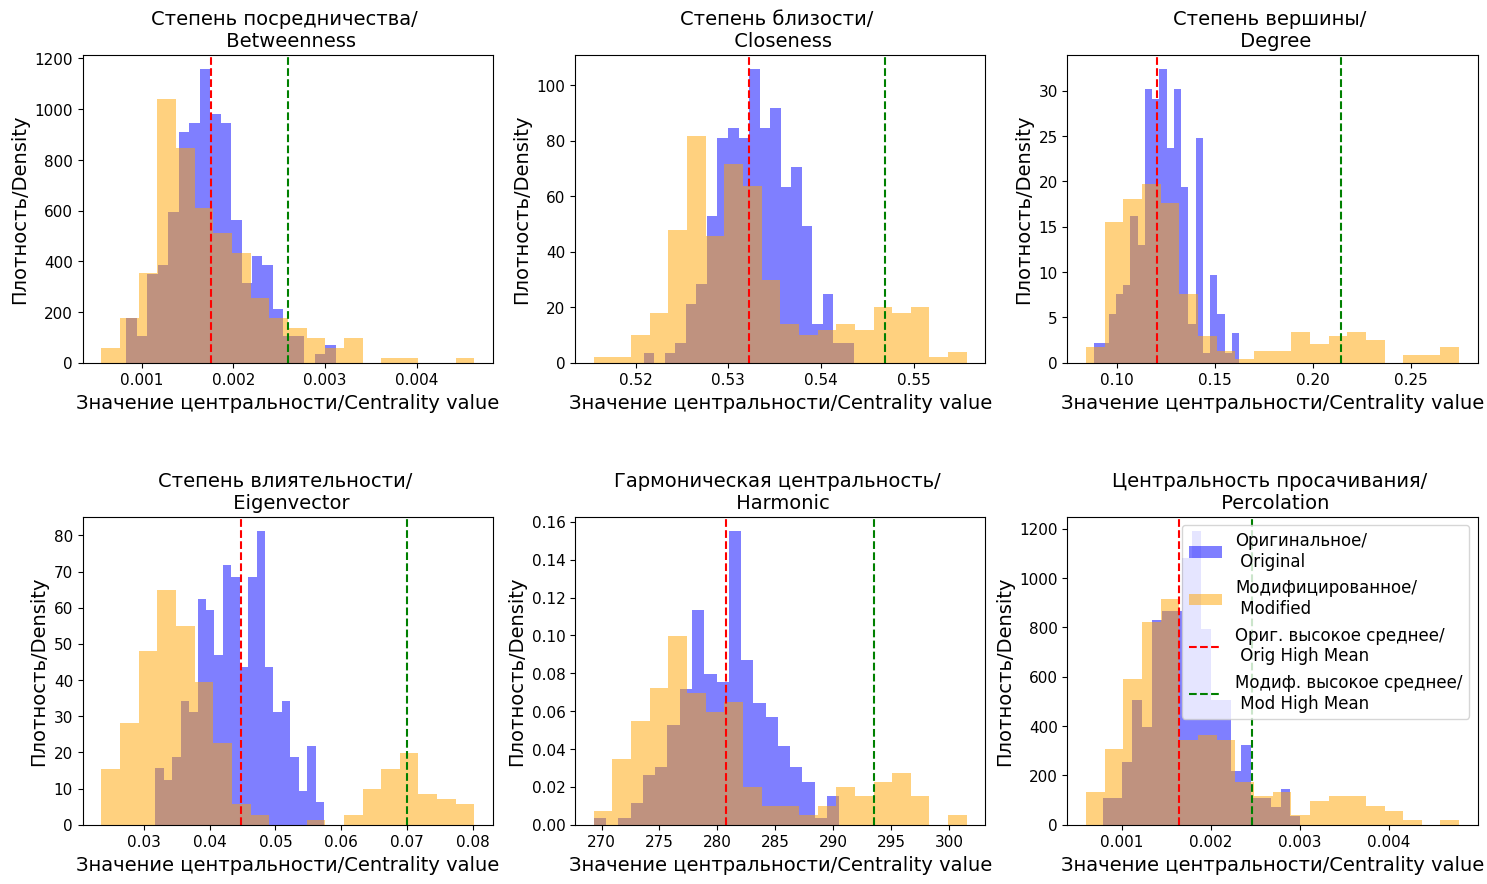

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from scipy.stats import powerlaw
import matplotlib.pyplot as plt
import os 
import copy

os.makedirs('sbm_arb', exist_ok=True)

def minmax_normalize(centrality_dict):
    """
    Выполняет min–max нормализацию словаря центральностей, 
    чтобы все значения лежали в диапазоне [0,1].
    Если все значения в centrality_dict одинаковые, то всем присваивается 1.0.
    """
    if not centrality_dict:
        return centrality_dict  # пустой словарь

    values = list(centrality_dict.values())
    min_val = min(values)
    max_val = max(values)
    if np.isclose(max_val, min_val):
        # Если все значения одинаковые, присвоим 1.0 всем
        for k in centrality_dict:
            centrality_dict[k] = 1.0
    else:
        diff = max_val - min_val
        for k in centrality_dict:
            centrality_dict[k] = (centrality_dict[k] - min_val) / diff
    return centrality_dict


def enforce_target_connectivity(G, cluster_sizes, p_intra, p_inter):
    """
    Корректирует граф G таким образом, чтобы фактические внутрикластерные (p_in) 
    и межкластерные (p_out) связи соответствовали целевым значениям p_intra и p_inter.
    """
    # Вычисляем число возможных внутрикластерных и межкластерных пар
    intra_possible = sum([size * (size - 1) // 2 for size in cluster_sizes])
    inter_possible = 0
    for i in range(len(cluster_sizes)):
        for j in range(i + 1, len(cluster_sizes)):
            inter_possible += cluster_sizes[i] * cluster_sizes[j]
            
    # Целевые количества рёбер
    target_intra_count = round(p_intra * intra_possible)
    target_inter_count = round(p_inter * inter_possible)
    
    # Определяем метки кластеров (предполагается, что вершины пронумерованы последовательно)
    n_neurons = G.number_of_nodes()
    labels = np.empty(n_neurons, dtype=int)
    start = 0
    for idx, size in enumerate(cluster_sizes):
        labels[start:start + size] = idx
        start += size

    # Собираем списки уже существующих рёбер по типу связи
    intra_edges = []
    inter_edges = []
    for (u, v) in list(G.edges()):
        if labels[u] == labels[v]:
            intra_edges.append((u, v))
        else:
            inter_edges.append((u, v))
    
    current_intra = len(intra_edges)
    current_inter = len(inter_edges)
    
    # Если количество внутрикластерных рёбер превышает целевое, удаляем лишние
    if current_intra > target_intra_count:
        extra = current_intra - target_intra_count
        indices = np.random.choice(len(intra_edges), size=extra, replace=False)
        for idx in indices:
            edge = intra_edges[idx]
            if G.has_edge(*edge):
                G.remove_edge(*edge)
    
    # Аналогично для межкластерных рёбер
    if current_inter > target_inter_count:
        extra = current_inter - target_inter_count
        indices = np.random.choice(len(inter_edges), size=extra, replace=False)
        for idx in indices:
            edge = inter_edges[idx]
            if G.has_edge(*edge):
                G.remove_edge(*edge)
                
    return G

def generate_sbm_with_high_centrality(
    n, cluster_sizes, p_intra, p_inter,
    target_cluster_index, proportion_high_centrality=0.2,
    centrality_type="degree", boost_factor=2
):
    """
    Генерация модели SBM с повышенной центральностью для выбранного кластера.
    После процедуры повышения центральности проводится компенсация, 
    чтобы итоговые значения p_in и p_out оставались равными p_intra и p_inter.
    """
    G = nx.Graph()
    G.add_nodes_from(range(n))  # ← явно добавляем все узлы заранее
    current_node = 0
    clusters = []

    # Формирование кластеров
    for size in cluster_sizes:
        cluster = list(range(current_node, current_node + size))
        clusters.append(cluster)
        current_node += size

    # Добавление внутрикластерных связей
    for cluster in clusters:
        for i in range(len(cluster)):
            for j in range(i + 1, len(cluster)):
                if np.random.rand() < p_intra:
                    G.add_edge(cluster[i], cluster[j])

    # Добавление межкластерных связей
    for idx1 in range(len(clusters)):
        for idx2 in range(idx1 + 1, len(clusters)):
            for u in clusters[idx1]:
                for v in clusters[idx2]:
                    if np.random.rand() < p_inter:
                        G.add_edge(u, v)
                        
    # fix_isolated_vertices(G, clusters)
    original_G = copy.deepcopy(G)
    # Определение целевого кластера и выбор узлов для повышения центральности
    target_cluster = clusters[target_cluster_index]
    num_high_centrality_nodes = int(proportion_high_centrality * len(target_cluster))
    high_centrality_nodes = np.random.choice(target_cluster, size=num_high_centrality_nodes, replace=False)

    # Для центральностей, требующих вычисления глобальных метрик
    if centrality_type in ["eigenvector", "pagerank", "betweenness", "closeness", "harmonic"]:
        if centrality_type == "eigenvector":
            centrality = nx.eigenvector_centrality(G, max_iter=1000)
        elif centrality_type == "pagerank":
            centrality = nx.pagerank(G)
        elif centrality_type == "betweenness":
            centrality = nx.betweenness_centrality(G)
        elif centrality_type == "closeness":
            centrality = nx.closeness_centrality(G)
        elif centrality_type == "harmonic":
            centrality = nx.harmonic_centrality(G)

        central_nodes = sorted(centrality, key=centrality.get, reverse=True)
        other_cluster_central_nodes = [node for node in central_nodes if node not in target_cluster][:int(0.1 * n)]

    # Механизм повышения центральности
    if centrality_type == "degree":
        for node in high_centrality_nodes:
            current_degree = G.degree[node]
            desired_degree = current_degree * boost_factor
            potential_neighbors = [v for v in G.nodes if v != node and not G.has_edge(node, v)]
            num_new_edges = int(min(desired_degree - current_degree, len(potential_neighbors)))
            if num_new_edges > 0:
                new_neighbors = np.random.choice(potential_neighbors, size=num_new_edges, replace=False)
                G.add_edges_from([(node, nn) for nn in new_neighbors])
             
    elif centrality_type in ["eigenvector", "pagerank", "betweenness", "closeness", "harmonic"]:
        for node in high_centrality_nodes:
            for neighbor in other_cluster_central_nodes:
                if not G.has_edge(node, neighbor) and np.random.rand() < p_inter * boost_factor:
                    G.add_edge(node, neighbor)
                    
    elif centrality_type == "local_clustering":
        for node in high_centrality_nodes:
            neighbors = list(G.neighbors(node))
            np.random.shuffle(neighbors)
            current_cc = nx.clustering(G, node)
            max_edges = len(neighbors) * (len(neighbors) - 1) // 2
            current_edges = int(current_cc * max_edges)
            desired_edges = min(int(current_edges * boost_factor), max_edges)
            edges_needed = desired_edges - current_edges
            if edges_needed <= 0:
                continue
            non_edges = [(u, v) for i, u in enumerate(neighbors) for v in neighbors[i+1:] if not G.has_edge(u, v)]
            add_edges = min(edges_needed, len(non_edges))
            if add_edges > 0:
                selected_edges = np.random.choice(len(non_edges), size=add_edges, replace=False)
                G.add_edges_from([non_edges[idx] for idx in selected_edges])
                    
    elif centrality_type == "percolation":
        all_high_degree_nodes = sorted(G.nodes, key=lambda x: G.degree[x], reverse=True)[:int(0.1 * n)]
        for node in high_centrality_nodes:
            for neighbor in all_high_degree_nodes:
                if not G.has_edge(node, neighbor) and np.random.rand() < p_inter * boost_factor:
                    G.add_edge(node, neighbor)
                    
    elif centrality_type == "cross_clique":
        cliques = list(nx.find_cliques(G))
        for node in high_centrality_nodes:
            other_cliques = [c for c in cliques if node not in c]
            for clique in other_cliques:
                candidates = [v for v in clique if not G.has_edge(node, v)]
                if candidates:
                    neighbor = np.random.choice(candidates)
                    if np.random.rand() < p_inter * boost_factor:
                        G.add_edge(node, neighbor)
    elif centrality_type == "random":
        pass
    else:
        raise ValueError("Unsupported centrality type.")
        
    G = enforce_target_connectivity(G, cluster_sizes, p_intra, p_inter)
    return original_G, G, high_centrality_nodes
        
def get_centrality(G, ctype, norm):
        if ctype == "degree":
            cent = nx.degree_centrality(G)
            if norm:
                cent = minmax_normalize(cent)
            return cent
        elif ctype == "betweenness":
            cent = nx.betweenness_centrality(G)
            if norm:
                cent = minmax_normalize(cent)
            return cent
        elif ctype == "eigenvector":
            cent = nx.eigenvector_centrality(G, max_iter=1000)
            if norm:
                cent = minmax_normalize(cent)
            return cent 
        elif ctype == "percolation":
            cent = nx.percolation_centrality(G)
            if norm:
                cent = minmax_normalize(cent)
            return cent
        elif ctype == "closeness":
            cent = nx.closeness_centrality(G)
            if norm:
                cent = minmax_normalize(cent)
            return cent
        elif ctype == "harmonic":
            cent = nx.harmonic_centrality(G)
            if norm:
                cent = minmax_normalize(cent)
            return cent
        elif ctype == "local_clustering":
            cent = nx.clustering(G)
            if norm:
                cent = minmax_normalize(cent)
            return cent
        elif ctype == "random":
            pass
        else:
            raise ValueError("Unsupported centrality type")

def measure_connectivity(C, cluster_sizes):
    """
    Функция для вычисления фактических долей внутрикластерных (p_in_measured)
    и межкластерных (p_out_measured) связей по итоговой матрице C.
    """
    n_neurons = C.shape[0]
    labels = np.empty(n_neurons, dtype=int)
    start = 0
    for idx, size in enumerate(cluster_sizes):
        labels[start:start + size] = idx
        start += size

    intra_possible = 0
    intra_actual = 0
    inter_possible = 0
    inter_actual = 0

    # Перебор пар нейронов (i < j)
    for i in range(n_neurons):
        for j in range(i+1, n_neurons):
            if labels[i] == labels[j]:
                intra_possible += 1
                if C[i, j]:
                    intra_actual += 1
            else:
                inter_possible += 1
                if C[i, j]:
                    inter_actual += 1
    print("intra_possible", intra_possible)
    print("intra_actual", intra_actual)
    print("inter_possible", inter_possible)
    print("inter_actual", inter_actual)
    p_in_measured = intra_actual / intra_possible if intra_possible > 0 else 0
    p_out_measured = inter_actual / inter_possible if inter_possible > 0 else 0
    return p_in_measured, p_out_measured
    

# Параметры эксперимента
n = 500
cluster_sizes = [250, 250]
p_intra = 0.15
p_inter = 0.1
target_cluster_index = 0
proportion_high_centrality = 0.2

# Формирование списка узлов целевого кластера
clusters = []
current_node = 0
for size in cluster_sizes:
    clusters.append(list(range(current_node, current_node + size)))
    current_node += size
target_cluster = clusters[target_cluster_index]

# Выбираем 6 мер центральности и соответствующие коэффициенты повышения
centralities = ['betweenness', 'closeness', 'degree', 'eigenvector', 'harmonic', 'percolation', 'random']
cent_rus = ['Степень посредничества', 'Степень близости', 'Степень вершины', 'Степень влиятельности', 'Гармоническая центральность', 'Центральность просачивания', 'Случайные узлы']
# boost_factors = {'degree': 1.1, 'betweenness': 2, 'closeness': 2, 'eigenvector': 1.1, 'percolation': 2, 'harmonic': 2, 'random': 0}
boost_factors = {'betweenness': 100, 'closeness': 50, 'degree': 2, 'eigenvector': 20, 'harmonic': 30, 'percolation': 50, 'random': 0}

# Создание фигуры с 6 подграфиками (2 ряда x 3 столбца)
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)  # Устанавливаем вертикальный отступ между рядами
axs = axs.flatten()


def circular_cluster_layout(clusters, cluster_centers, cluster_radius=1):
    """
    Располагает узлы каждого кластера равномерно по окружности вокруг заданного центра.
    
    clusters: список кластеров (списки узлов)
    cluster_centers: список центров каждого кластера (кортежи с координатами x, y)
    cluster_radius: радиус окружности, на которой располагаются узлы кластера
    """
    pos = {}
    for cluster_idx, cluster in enumerate(clusters):
        center_x, center_y = cluster_centers[cluster_idx]
        n_nodes = len(cluster)
        angles = np.linspace(0, 2 * np.pi, n_nodes, endpoint=False)
        for node, angle in zip(cluster, angles):
            x = center_x + cluster_radius * np.cos(angle)
            y = center_y + cluster_radius * np.sin(angle)
            pos[node] = (x, y)
    return pos

def plot_graph(G, pos, title, node_colors, highlight_high_edges=False, high_nodes=None, added_edges=None):
    """
    Визуализация графа с подсветкой управляющих узлов и добавленных ребер.
    """
    plt.figure(figsize=(7, 7))
    
    # Отрисовка всех узлов основным цветом
    nx.draw_networkx_nodes(G, pos, node_color=[node_colors[node] for node in G.nodes()], node_size=500)
    
    # Отрисовка управляющих узлов поверх (если заданы)
    if high_nodes is not None:
        nx.draw_networkx_nodes(G, pos, nodelist=high_nodes, node_color='red', node_size=500)
    
    # Отрисовка ребер
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    # Подсветка добавленных ребер
    if added_edges:
        nx.draw_networkx_edges(G, pos, edgelist=added_edges, edge_color='green', width=3)
    
    # Подсветка ребер управляющих узлов (если нужно)
    if highlight_high_edges and high_nodes is not None:
        high_edges = [edge for edge in G.edges() if (edge[0] in high_nodes or edge[1] in high_nodes)]
        nx.draw_networkx_edges(G, pos, edgelist=high_edges, edge_color='red', width=2)
    
    nx.draw_networkx_labels(G, pos, font_size=16)
    plt.title(title, loc='left', fontsize=20)
    plt.tight_layout()
    plt.axis('off')
    
def plot_adjacency_add(G, added_edges=None, high_nodes=None, title=''):
    """
    Визуализация матрицы смежности G с подсветкой добавленных ребер в зеленый цвет.
    added_edges: список кортежей ребер, которые нужно выделить (должны быть в G).
    high_nodes: список узлов, которые нужно подсветить на осях.
    """
    nodelist = sorted(G.nodes())
    node_idx = {node: i for i, node in enumerate(nodelist)}
    A = nx.to_numpy_array(G, nodelist=nodelist)
    # Создаем цветную матрицу: по умолчанию все связи белые
    color_matrix = np.zeros((A.shape[0], A.shape[1], 3))
    color_matrix[A == 1] = [1, 1, 1]
    # Подсветка добавленных ребер
    if added_edges:
        for u, v in added_edges:
            i, j = node_idx[u], node_idx[v]
            color_matrix[i, j] = [0, 1, 0]
            color_matrix[j, i] = [0, 1, 0]
    plt.figure(figsize=(7, 7))
    # Размещаем заголовок левее области графика
    plt.title(title, loc='left', x=-0.05, fontsize=20)
    plt.imshow(color_matrix, interpolation='none')
    
    # Устанавливаем метки с подсветкой управляющих узлов
    print(np.arange(len(nodelist)))
    plt.xticks(np.arange(len(nodelist)), labels=nodelist, fontsize=16)
    plt.yticks(np.arange(len(nodelist)), labels=nodelist, fontsize=16)

    print(high_nodes)
    # Подсветка меток управляющих узлов
    if high_nodes is not None:
        # Для оси X
        for idx, label in enumerate(plt.gca().get_xticklabels()):
            node = int(label.get_text())
            if node in high_nodes:
                label.set_color('red')
                label.set_fontweight('bold')
        # Для оси Y
        for idx, label in enumerate(plt.gca().get_yticklabels()):
            node = int(label.get_text())
            if node in high_nodes:
                label.set_color('red')
                label.set_fontweight('bold')
    
    plt.tight_layout()
    plt.grid(False)

    
# Определяем цветовую схему для кластеров
node_colors = {}
color_map = ['skyblue', 'lightgreen']
for idx, cluster in enumerate(clusters):
    for node in cluster:
        node_colors[node] = color_map[idx]
    
# Позиции для графов (визуализация в 2 кластера)
cluster_centers = [(-3, 0), (3, 0)]

for i, cent in enumerate(centralities):
    bf = boost_factors[cent]
    # Генерация модифицированного графа с повышенной центральностью
    original_G, modified_G, high_nodes = generate_sbm_with_high_centrality(
        n, cluster_sizes, p_intra, p_inter,
        target_cluster_index, proportion_high_centrality,
        cent, bf
    )
    print(cent.capitalize())
    if cent.capitalize() != 'Random':
        # Вычисление значений центральности для целевого кластера
        norm = False
        orig_c = get_centrality(original_G, cent, norm)
        mod_c = get_centrality(modified_G, cent, norm)
        
        orig_vals = [orig_c[n] for n in target_cluster]
        mod_vals = [mod_c[n] for n in target_cluster]

        # Для выбранных узлов, для которых применялось повышение
        orig_high = [orig_c[n] for n in high_nodes]
        mod_high = [mod_c[n] for n in high_nodes]

        print("high nodes", high_nodes)
        ax = axs[i]
        ax.hist(orig_vals, bins=20, alpha=0.5, label='Оригинальное/\n Original', density=True, color='blue')
        ax.hist(mod_vals, bins=20, alpha=0.5, label='Модифицированное/\n Modified', density=True, color='orange')
        ax.axvline(np.mean(orig_high), color='red', linestyle='--', label='Ориг. высокое среднее/\n Orig High Mean')
        ax.axvline(np.mean(mod_high), color='green', linestyle='--', label='Модиф. высокое среднее/\n Mod High Mean')
        ax.set_title(f'{cent_rus[i]}/ \n {cent.capitalize()}', fontsize=14)
        ax.set_xlabel('Значение центральности/Centrality value', fontsize=14)
        ax.set_ylabel('Плотность/Density', fontsize=14)
        ax.tick_params(axis='x', labelsize=11)
        ax.tick_params(axis='y', labelsize=11)
        if i == 5:
            ax.legend(fontsize=12)
        print("Разница между mod и orig:",100-np.mean(orig_high)*100/np.mean(mod_high),"%")
    else:
        pass

    # --- Сохраняем матрицы смежности ---
    plot_adjacency_add(original_G, title="а)")
    plt.savefig(f"sbm_arb/adjacency_{cent}_orig.png")
    plt.close()

    isolated = [node for node in original_G.nodes() if original_G.degree[node] == 0]
    print("Изолированные узлы в original:", isolated if isolated else "отсутствуют")

    added = set(modified_G.edges()) - set(original_G.edges())
    plot_adjacency_add(modified_G, added_edges=list(added), high_nodes=high_nodes,
                         title='б)')
    plt.savefig(f"sbm_arb/adjacency_{cent}_mod.png")
    plt.close()
    
    pos_orig = circular_cluster_layout(clusters, cluster_centers, cluster_radius=2)
    pos_mod = circular_cluster_layout(clusters, cluster_centers, cluster_radius=2)  # или иной layout

    # --- Сохраняем визуализации графа ---
    plot_graph(original_G, pos_orig,
           title='в)',
           node_colors=node_colors,
           highlight_high_edges=False, high_nodes=None,
           added_edges=None)
    plt.savefig(f"sbm_arb/graph_{cent}_orig.png", bbox_inches='tight', pad_inches=0.1)
    plt.close()

    plot_graph(modified_G, pos_mod,
               title='г)',
               node_colors=node_colors,
               highlight_high_edges=False, 
               high_nodes=high_nodes,  # Передаем узлы для подсветки
               added_edges=list(added))
    plt.savefig(f"sbm_arb/graph_{cent}_mod.png", bbox_inches='tight', pad_inches=0.1)
    plt.close()

    # --- Вычисляем фактические плотности ---
    C_total_matrix = nx.to_numpy_array(original_G)
    p_in_measured, p_out_measured = measure_connectivity(C_total_matrix, cluster_sizes)
    print(f"Фактическая original p_in {cent.capitalize()}: {p_in_measured:.3f}")
    print(f"Фактическая original p_out {cent.capitalize()}: {p_out_measured:.3f}")

    C_total_matrix = nx.to_numpy_array(modified_G)
    p_in_measured, p_out_measured = measure_connectivity(C_total_matrix, cluster_sizes)
    print(f"Фактическая modified p_in {cent.capitalize()}: {p_in_measured:.3f}")
    print(f"Фактическая modified p_out {cent.capitalize()}: {p_out_measured:.3f}")



plt.show()

# Сохранение итоговой фигуры в PDF
fig.savefig('6_centrality_distributions.pdf')

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Настройки для максимально плотной компоновки
plt.rcParams['figure.autolayout'] = False  # Отключаем авто-лейаут

# Создаем фигуру с 2 рядами и 3 столбцами
fig, axes = plt.subplots(2, 2, figsize=(10, 10), 
                        gridspec_kw={'wspace': 0, 'hspace': 0})

# Полностью убираем все отступы и промежутки
plt.subplots_adjust(left=0.02, right=0.98, 
                    bottom=0.02, top=0.95,
                    wspace=0, hspace=0)

# Загружаем и отображаем изображения
for row_idx in range(2):
    for col_idx in range(2):
        ax = axes[row_idx, col_idx]
        
        # Загрузка изображений (замените пути)
        if row_idx == 0:
            img = mpimg.imread(f'sbm_arb/adjacency_degree_{["orig", "mod"][col_idx]}.png')
        else:
            img = mpimg.imread(f'sbm_arb/graph_degree_{["orig", "mod"][col_idx]}.png')
            
        # Отображение с заполнением всего subplot
        ax.imshow(img, aspect='auto')
        ax.axis('off')

# Сохраняем с минимальными отступами
plt.savefig('combined_plot.png', 
           bbox_inches='tight', 
           pad_inches=0.02, 
           dpi=300)
plt.close()